# Notebook showing use of Zygote's autodiff package

In [1]:
using Zygote
using Plots
using Statistics

### Create function for evaluation by element (not vecotrized)

In [10]:
f(x,a,b) = a*x + b
loss(yTrue,yPred) = sqrt((yTrue-yPred)^2)

function oneStep(x,a,b,yTrue)
    out = f(x,a,b)
    lossVal = loss(yTrue,out)
end

oneStep (generic function with 1 method)

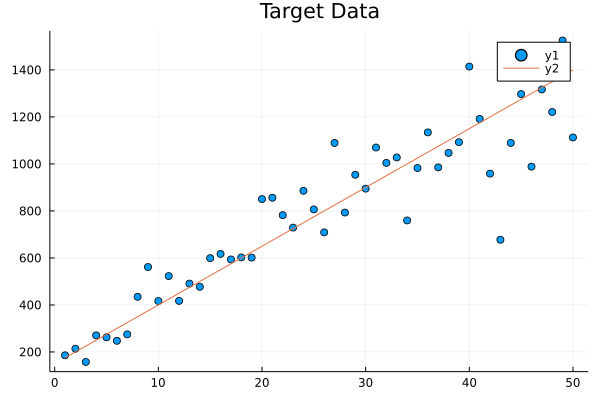

In [40]:
lengthLine = 50
target_a =25
target_b =150
noiseFac = 0.15

xVals = 1:lengthLine

line = ones(lengthLine)
for idx in range(1,length=lengthLine)
    line[idx] = f(xVals[idx],target_a,target_b)
end
noisyLine = line .+ line .*noiseFac .* rand([-1,1],lengthLine) .* randn(lengthLine)
plot([1:length(noisyLine)],noisyLine,seriestype = :scatter,title="Target Data")
plot!([1:length(noisyLine)],line)

### Implement gradient descent using gradients

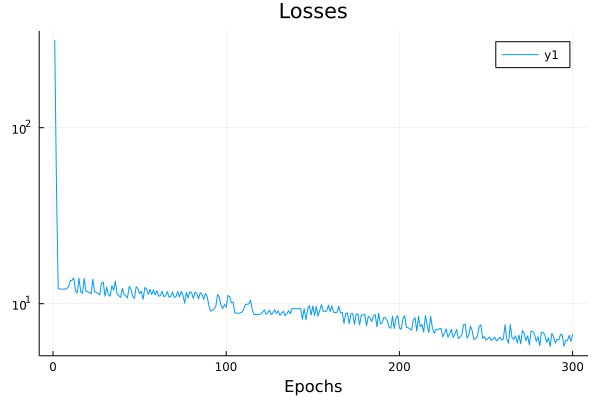

In [102]:
lr = 0.01
epochs = 300
a1 = rand(1:300)
b1 = rand(1:300)
epochLosses = []
aValsEpochs = []
bValsEpochs = []
for e in 1:epochs
    aVals = []
    bVals = []
    losses = []
    for xIdx in 1:lengthLine
        l, grads = withgradient(oneStep,xVals[xIdx],a1,b1,line[xIdx])
        a1 -= grads[2]*lr
        b1 -= grads[3]*lr
        append!(aVals,a1)
        append!(bVals,b1)
        append!(losses,l)
    end
    append!(epochLosses,mean(losses))
    append!(aValsEpochs,mean(aVals))
    append!(bValsEpochs,mean(bVals))
end
plot([1:length(epochLosses)],epochLosses,title="Losses",xlabel="Epochs", yaxis=:log)

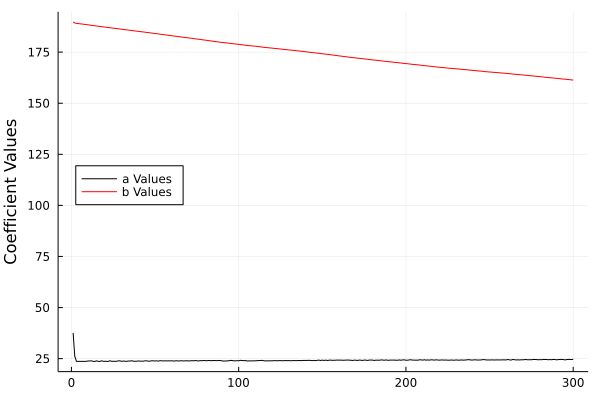

In [105]:
plot([1:length(aValsEpochs)],aValsEpochs,color=:black,label="a Values",legend=:left,ylabel="Coefficient Values")
plot!([1:length(bValsEpochs)],bValsEpochs,color=:red,label="b Values")

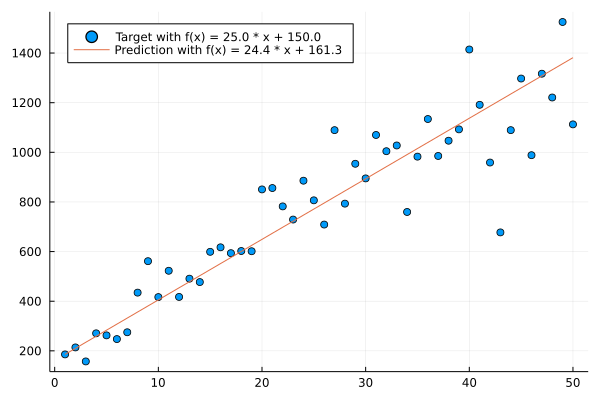

In [104]:
linePred = ones(lengthLine)
for idx in range(1,length=length(line))
    linePred[idx] = f(idx,a1,b1)
end

begin
plot(1:lengthLine,noisyLine,seriestype = :scatter,label="Target with f(x) = $(round(target_a,digits = 2)) * x + $(round(target_b,digits=2))",legend=:topleft)
plot!(1:lengthLine, linePred,label="Prediction with f(x) = $(round(a1,digits = 2)) * x + $(round(b1,digits=2))")
end

### Vecotorized approach

In [106]:
xValsVec = 1:lengthLine
fVec(x,a,b) = x.*a .+b
lossVec(yTrue,out) = mean(sqrt.((yTrue.-out).^2))
function oneStepVec(x,a,b,yTrue)
	out = fVec(x,a,b)
	lossVal = lossVec(yTrue,out)
end

oneStepVec (generic function with 1 method)

In [142]:
function runDesc(x,y,lrVec,epochsVec)
    lossesVec = []
    a2 = rand(minimum(x):maximum(x))
    b2 = rand(minimum(x):maximum(x))
    for e in 1:epochsVec
        lVec, gradsVec = withgradient(oneStepVec,x,a2,b2,y)
        a2 -= gradsVec[2]*lrVec
        b2 -= gradsVec[3]*lrVec
        append!(lossesVec,lVec)
    end
    return lossesVec, a2,b2
end

runDesc (generic function with 1 method)

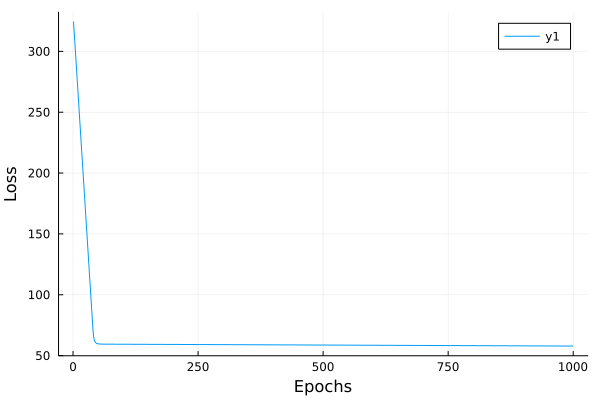

In [153]:
lineTrue = fVec(xValsVec, target_a,target_b)
lossesVec, aPred,bPred = runDesc(xValsVec,lineTrue,1e-2, 1000)
plot(1:length(lossesVec),lossesVec,seriestype = :line,xlabel="Epochs",ylabel="Loss")

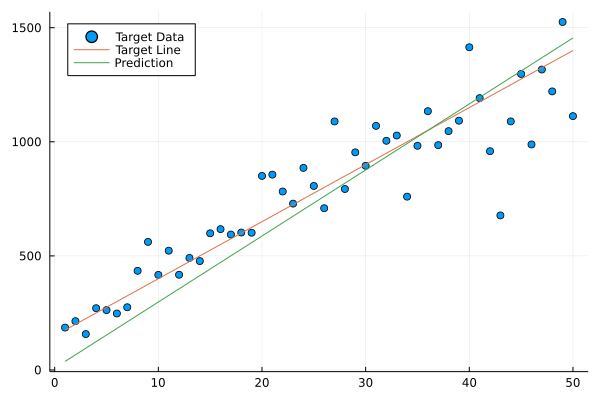

In [144]:
linePredVec = fVec(xValsVec, aPred,bPred)

plot(xValsVec,noisyLine,seriestype = :scatter,label="Target Data",legend=:topleft)
plot!(xValsVec, line,label="Target Line")
plot!(xValsVec, linePredVec,label="Prediction")

### With data normalisation

In [145]:
function transform(x)
	xStd = std(x)
	xMean = mean(x)
	xTransform = (x.-xMean) ./ xStd
	return xTransform, xStd, xMean
end

function invTransform(x,xStd,xMean)
	round.((x.*xStd).+xMean,digits=8)
end

invTransform (generic function with 1 method)

In [146]:
xValsVecTr, xStd, xMean = transform(xValsVec)
lineTr, lineStd, lineMean = transform(line)

println("Line equal to inverse transform of transformed line: $(line == invTransform(lineTr, lineStd, lineMean))")

Line equal to inverse transform of transformed line: true


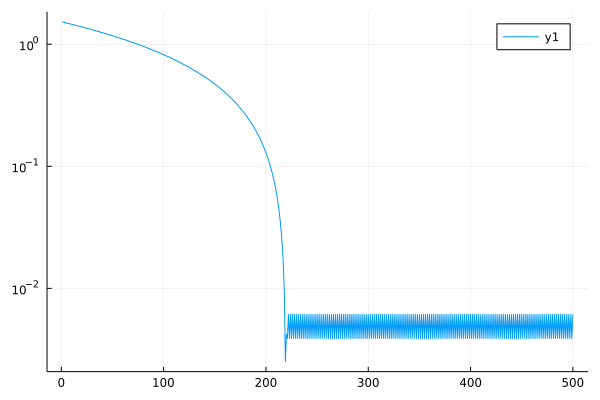

In [156]:
lossesVec2, aPred,bPred = runDesc(xValsVecTr,lineTr,1e-2, 500)
plot(1:length(lossesVec2),lossesVec2,seriestype = :line,yaxis=:log)

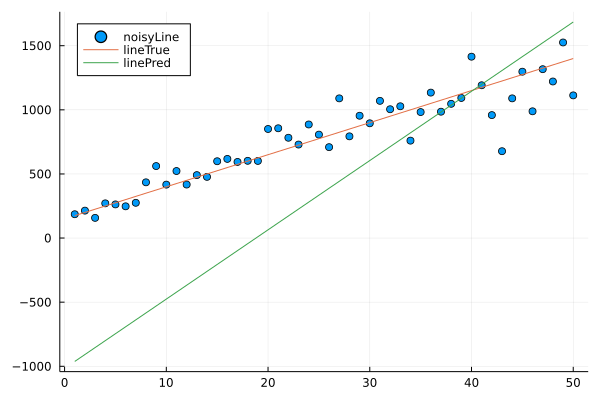

In [157]:
linePredVec = fVec(xValsVecTr, aPred,bPred)

plot(1:lengthLine,noisyLine,seriestype = :scatter,label="noisyLine")
plot!(1:lengthLine, line,label="lineTrue")
plot!(1:lengthLine, invTransform(linePredVec,lineMean,lineStd),label="linePred",legend=:topleft)


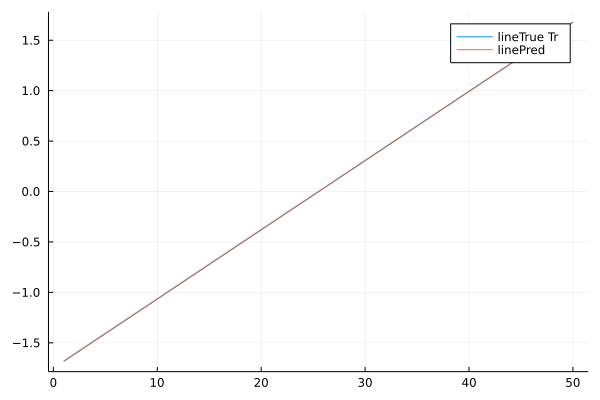

In [158]:
plot(1:lengthLine,noisyLine,seriestype = :scatter,label="noisyLine")
plot(1:lengthLine, transform(line),label="lineTrue Tr")
plot!(1:lengthLine, linePredVec,label="linePred")


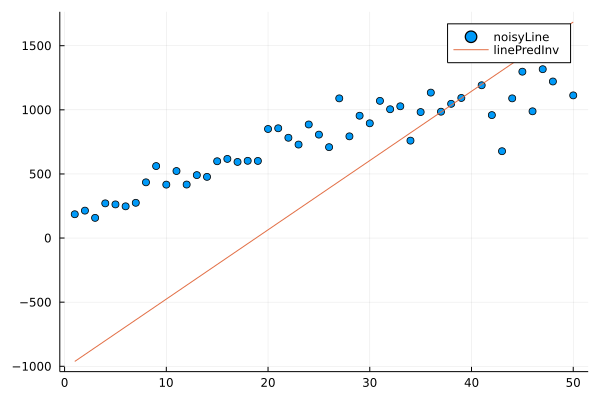

In [159]:
linePredInv = invTransform(linePredVec,lineMean,lineStd)

plot(1:lengthLine,noisyLine,seriestype = :scatter,label="noisyLine")
plot!(1:lengthLine, linePredInv,label="linePredInv")